In [1]:
# Librairies imports
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np


In [2]:
# Hyperparameters
IMAGE_SIZE = 256
BATCH_SIZE = 32
VAL_SPLIT = 0.2
TEST_SPLIT = 0.1
CHANNELS=3
EPOCHS=50

Import the datasets and change it into tensorflow dataset object:
- Source of the dataset: https://www.kaggle.com/datasets/faysalmiah1721758/potato-dataset

In [3]:
data_dir = "..\Datasets"
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    labels='inferred',
    seed = 42,
    label_mode='int',
    validation_split=None,
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE,
)

Found 2152 files belonging to 3 classes.


<>:1: SyntaxWarning: invalid escape sequence '\D'
<>:1: SyntaxWarning: invalid escape sequence '\D'
C:\Users\Ronan\AppData\Local\Temp\ipykernel_19064\1269206948.py:1: SyntaxWarning: invalid escape sequence '\D'
  data_dir = "..\Datasets"


In [4]:
# Name of the classes
class_names = dataset.class_names
print(class_names)

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']


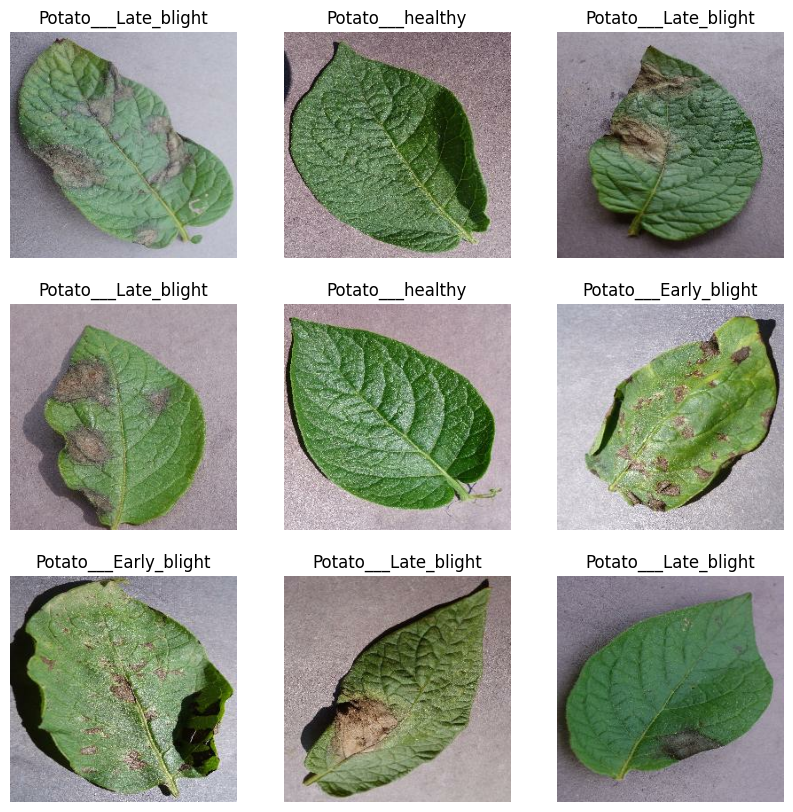

In [5]:
# Visualize the data
plt.figure(figsize=(10, 10))
for images, labels in dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [6]:
# Display the shape of batched train samples
for image_batch, labels_batch in dataset:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 256, 256, 3)
(32,)


Split the dataset into the training, testing and the validation subsets

In [7]:
def subset_creation(dataset, train_split=0.7, test_split=0.1, val_split=0.2, shuffle=True, shuffle_size=100):

    assert (train_split + test_split + val_split) == 1

    size_dataset = len(dataset)

    if shuffle:
            dataset = dataset.shuffle(shuffle_size, seed=123)
    
    train_size = int(size_dataset * train_split)
    test_size = int(size_dataset * test_split)
    val_size = int(size_dataset * val_split)


    train_dataset = dataset.take(train_size)
    test_dataset = dataset.skip(train_size).take(test_size)
    val_dataset = dataset.skip(test_size).take(val_size)

    return train_dataset, val_dataset, test_dataset

    


In [8]:
train_ds, val_ds, test_ds = subset_creation(dataset)

In [9]:
print(f"""
    ----------------------------------
    Dataset split:
        - train split: {len(train_ds)}
        - val split: {len(val_ds)}
        - test split: {len(test_ds)}
    ----------------------------------
    """
)


    ----------------------------------
    Dataset split:
        - train split: 47
        - val split: 13
        - test split: 6
    ----------------------------------
    


Cache the dataset

In [10]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Normalization and Resizing of the images for prediction

In [11]:

resize_and_rescale = tf.keras.Sequential([
  tf.keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  tf.keras.layers.Rescaling(1./255),
])

Proof that the images are rescaled

In [12]:
normalized_ds = train_ds.map(lambda x, y: (resize_and_rescale(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [13]:
# Import keras api 
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

Image augmentation

In [14]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.2),
  #tf.keras.layers.RandomContrast(0.2),
  #tf.keras.layers.RandomCrop(height=1, width=1),
  #tf.keras.layers.RandomZoom(0.2),
  #tf.keras.layers.RandomTranslation(height_factor=0.2, width_factor=0.2),
  #tf.keras.layers.RandomBrightness(factor=0.2)
])

In [15]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

Model creation

In [16]:

input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

model = tf.keras.models.Sequential([
    resize_and_rescale,
    tf.keras.layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(CHANNELS, activation='softmax'),
])

model.build(input_shape=input_shape)

c:\Users\Ronan\Documents\ML\CNN\Potato_Disease_Classification_Project\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [17]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 3)                │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [19]:
filepath="saved_models/best_model.keras"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
es = EarlyStopping(monitor='val_accuracy', patience=10)
callbacks_list = [checkpoint, es]

In [20]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
    callbacks=callbacks_list
)

Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step - accuracy: 0.4567 - loss: 0.9511
Epoch 1: val_accuracy improved from -inf to 0.54567, saving model to saved_models/best_model.keras
47/47 ━━━━━━━━━━━━━━━━━━━━ 23s 446ms/step - accuracy: 0.4577 - loss: 0.9503 - val_accuracy: 0.5457 - val_loss: 0.8759
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step - accuracy: 0.6048 - loss: 0.8403
Epoch 2: val_accuracy improved from 0.54567 to 0.69952, saving model to saved_models/best_model.keras
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 421ms/step - accuracy: 0.6055 - loss: 0.8390 - val_accuracy: 0.6995 - val_loss: 0.7163
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step - accuracy: 0.7564 - loss: 0.5727
Epoch 3: val_accuracy improved from 0.69952 to 0.72596, saving model to saved_models/best_model.keras
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 423ms/step - accuracy: 0.7565 - loss: 0.5723 - val_accuracy: 0.7260 - val_loss: 0.6235
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step - accuracy: 0.8243 - loss: 0.4304

Load the best model

In [41]:
best_model = tf.keras.models.load_model(filepath)

In [42]:
scores = best_model.evaluate(test_ds)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - accuracy: 0.9950 - loss: 0.0318


False Negatives TO DO

In [43]:
m = tf.keras.metrics.FalseNegatives()
m.update_state([0, 1, 1, 1], [0, 1, 0, 0])

result = m.result()

In [44]:
print("Accuracy: %.2f%%"% (scores[1]*100))

Accuracy: 98.96%


In [45]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 47}

In [46]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [47]:
history.history['loss'][:5] # show loss for first 5 epochs

[0.912941038608551,
 0.7779859304428101,
 0.5515428781509399,
 0.4020277261734009,
 0.3001263737678528]

In [48]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [49]:
acc

[0.5006648898124695,
 0.6389627456665039,
 0.7619680762290955,
 0.8417553305625916,
 0.8776595592498779,
 0.8989361524581909,
 0.9195478558540344,
 0.9168882966041565,
 0.9268617033958435,
 0.9301861524581909,
 0.947473406791687,
 0.9328457713127136,
 0.9428191781044006,
 0.9581117033958435,
 0.967420220375061,
 0.914893627166748,
 0.9594414830207825,
 0.9614361524581909,
 0.9607712626457214,
 0.9847074747085571,
 0.9827127456665039,
 0.9368351101875305,
 0.96875,
 0.977393627166748,
 0.9740691781044006,
 0.9753989577293396,
 0.9820478558540344,
 0.957446813583374,
 0.9767287373542786,
 0.9867021441459656,
 0.9827127456665039,
 0.9827127456665039,
 0.9833776354789734,
 0.9813829660415649,
 0.9827127456665039,
 0.9760638475418091,
 0.988696813583374,
 0.991356372833252,
 0.9960106611251831,
 0.980053186416626,
 0.9807180762290955,
 0.9933510422706604,
 0.9933510422706604,
 0.978723406791687]

In [50]:
val_acc

[0.5456730723381042,
 0.6995192170143127,
 0.7259615659713745,
 0.8533653616905212,
 0.8677884340286255,
 0.8942307829856873,
 0.8894230723381042,
 0.8966346383094788,
 0.8822115659713745,
 0.9038461446762085,
 0.9206730723381042,
 0.901442289352417,
 0.9182692170143127,
 0.9302884340286255,
 0.754807710647583,
 0.9471153616905212,
 0.9230769276618958,
 0.9086538553237915,
 0.9302884340286255,
 0.9399038553237915,
 0.9038461446762085,
 0.9278846383094788,
 0.9375,
 0.9375,
 0.963942289352417,
 0.9831730723381042,
 0.9302884340286255,
 0.963942289352417,
 0.9519230723381042,
 0.9543269276618958,
 0.8894230723381042,
 0.973557710647583,
 0.9759615659713745,
 0.9879807829856873,
 0.8942307829856873,
 0.901442289352417,
 0.96875,
 0.9759615659713745,
 0.9831730723381042,
 0.942307710647583,
 0.9807692170143127,
 0.9615384340286255,
 0.9783653616905212,
 0.9663461446762085]

In [51]:
loss

[0.912941038608551,
 0.7779859304428101,
 0.5515428781509399,
 0.4020277261734009,
 0.3001263737678528,
 0.25169816613197327,
 0.19915054738521576,
 0.219815194606781,
 0.1813858449459076,
 0.17015708982944489,
 0.1298278272151947,
 0.16398094594478607,
 0.1388734132051468,
 0.1096828430891037,
 0.08951893448829651,
 0.2131628692150116,
 0.10526696592569351,
 0.09476621448993683,
 0.10166037082672119,
 0.046610232442617416,
 0.04206471890211105,
 0.17285500466823578,
 0.07961061596870422,
 0.058931615203619,
 0.06237093359231949,
 0.061442673206329346,
 0.050425540655851364,
 0.11188604682683945,
 0.06610787659883499,
 0.03410683572292328,
 0.044476840645074844,
 0.040338654071092606,
 0.040398698300123215,
 0.05224376171827316,
 0.04495863616466522,
 0.058896202594041824,
 0.03398805111646652,
 0.02076701447367668,
 0.015970749780535698,
 0.05075943097472191,
 0.0520084984600544,
 0.02150057442486286,
 0.017849024385213852,
 0.06897375732660294]

In [52]:
val_loss

[0.8759282231330872,
 0.7162883281707764,
 0.6234508156776428,
 0.4021463394165039,
 0.33248668909072876,
 0.2947724759578705,
 0.29837843775749207,
 0.2818391025066376,
 0.2786960005760193,
 0.3086031675338745,
 0.19275307655334473,
 0.23524196445941925,
 0.23555460572242737,
 0.20865097641944885,
 0.6816527843475342,
 0.1522677093744278,
 0.22736510634422302,
 0.22351202368736267,
 0.19027365744113922,
 0.16921743750572205,
 0.3433184325695038,
 0.17472968995571136,
 0.14540082216262817,
 0.20290789008140564,
 0.11813635379076004,
 0.10057493299245834,
 0.22840705513954163,
 0.12980917096138,
 0.11515036225318909,
 0.11756189167499542,
 0.3376483619213104,
 0.10254816710948944,
 0.11933402717113495,
 0.08218163996934891,
 0.26844242215156555,
 0.2939835488796234,
 0.12320762127637863,
 0.0868164598941803,
 0.07311631739139557,
 0.15158231556415558,
 0.0659056231379509,
 0.1290562003850937,
 0.07848071306943893,
 0.10348325222730637]

In [53]:
#ES_EPOCH = 26

#plt.figure(figsize=(8, 8))
#plt.subplot(1, 2, 1)
#plt.plot(range(ES_EPOCH), acc, label='Training Accuracy')
#plt.plot(range(ES_EPOCH), val_acc, label='Validation Accuracy')
#plt.legend(loc='lower right')
#plt.title('Training and Validation Accuracy')

#plt.subplot(1, 2, 2)
#plt.plot(range(ES_EPOCH), loss, label='Training Loss')
#plt.plot(range(ES_EPOCH), val_loss, label='Validation Loss')
#plt.legend(loc='upper right')
#plt.title('Training and Validation Loss')
#plt.show()

first image to predict


actual label: Potato___Late_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
predicted label: Potato___Late_blight


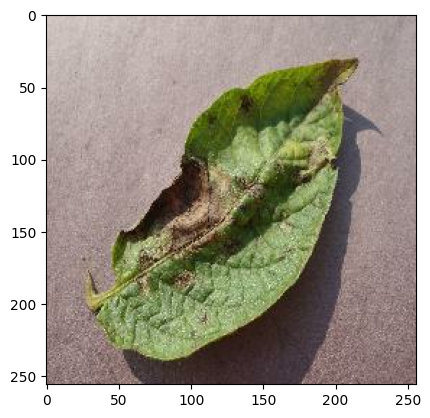

In [54]:
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = best_model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [55]:

def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = best_model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


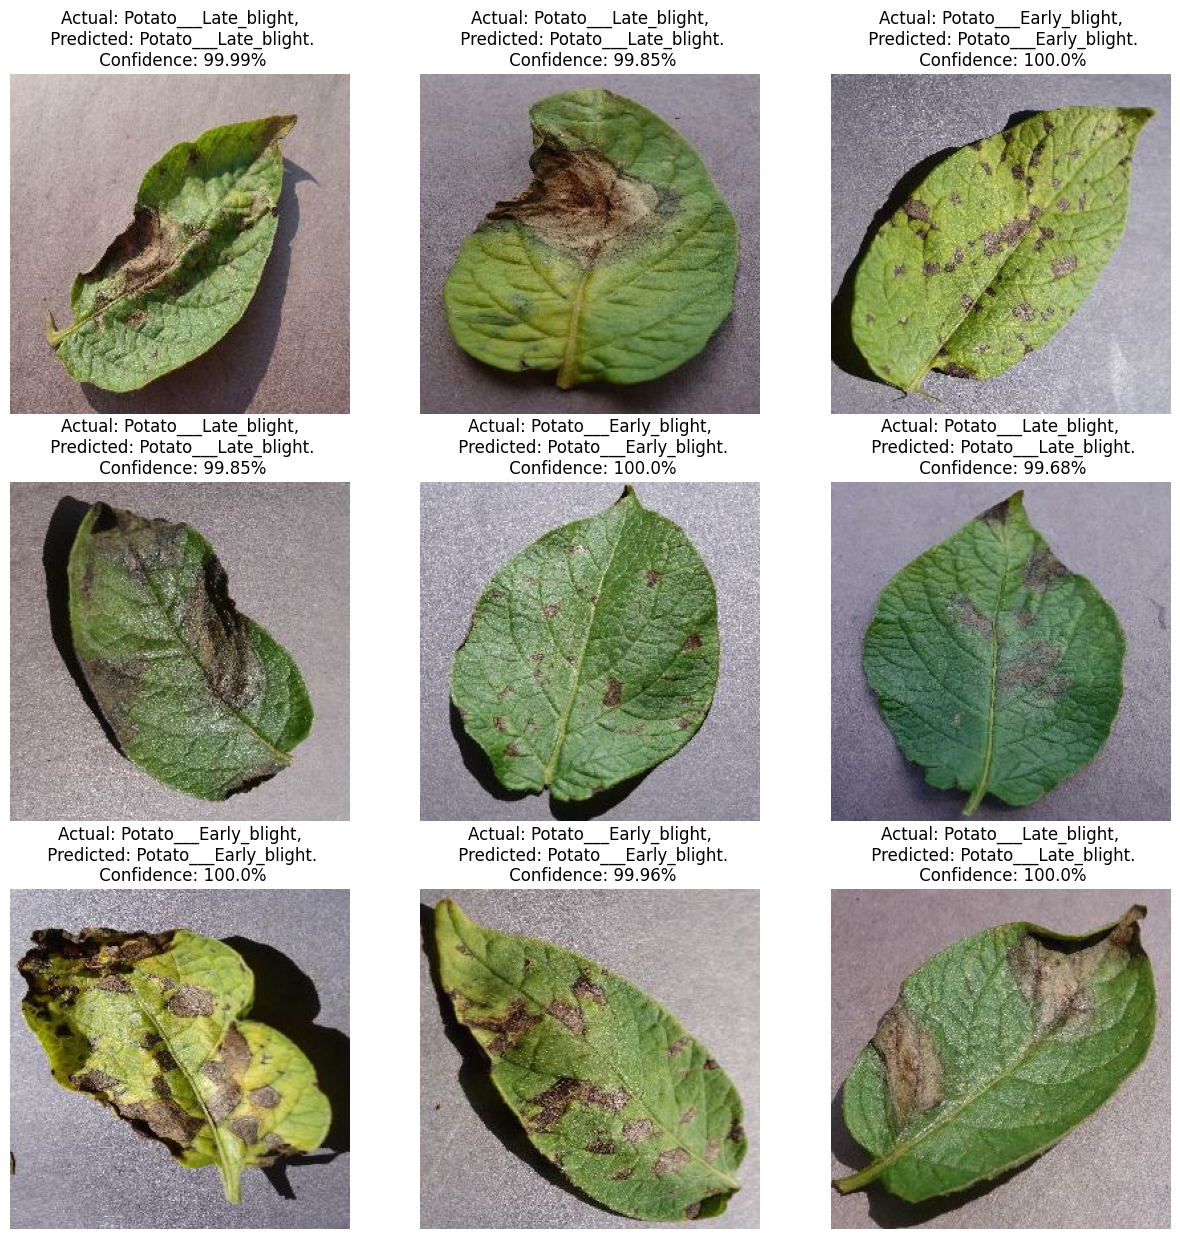

In [56]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")